### Loading the data

In [1]:
from dataset import Dataset

dataset = Dataset()
dataset.inspect()

8792 images of vehicles
8968 images of non vehicles


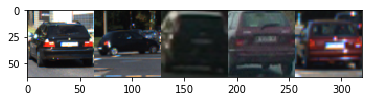

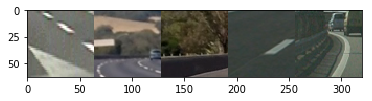

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random

%matplotlib inline

cars_images = []
non_cars_images = []

for i in range(5):
    cars_images.append(mpimg.imread(random.choice(dataset.cars)))

cars_images = np.concatenate(cars_images, axis=1)
plt.imshow(cars_images)
plt.show()

for i in range(5):
    non_cars_images.append(mpimg.imread(random.choice(dataset.non_cars)))

non_cars_images = np.concatenate(non_cars_images, axis=1)
plt.imshow(non_cars_images)
plt.show()


In [4]:
from hog_classifier import *

In [5]:
cla = HOGClassifier(dataset)

In [6]:
cla.extract_data_features()

82.67 Seconds to extract HOG features...
Feature vectors shape: (17760, 6108)


In [7]:
cla.scale_features()
cla.get_labels()
cla.split_up_data()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
X_train shape: (14209, 6108)
14209 train samples
(14209, 6108) X_train.shape
(14209,) y_train.shape
(3551, 6108) X_test
(3551,) y_test shape
(17760, 6108) scaled_X shape
(17760,) y  shape


In [8]:
cla.train()

18.98 Seconds to train SVC...


In [9]:
cla.accuracy()

Test Accuracy of SVC =  0.9462


In [10]:
cla.save_data()

Saving data to pickle file...
Data cached in pickle file.


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

cars_nval = len(cla.car_features)

preds = cla.svc.predict(cla.car_features)
misclassifieds = np.array(preds != np.ones(cars_nval))
inds = np.where(preds != np.ones(cars_nval))
inds = np.ravel(inds)
misclassifieds = [ dataset.cars[i] for i in inds]
    
fig, axes = plt.subplots(2,10,figsize=(20,5))
fig.subplots_adjust(hspace=0.2, wspace=0.05)
    
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(misclassifieds[i]))
    xlabel = "false neg {0}".format(i)
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])
    

plt.show()
print('number of misclassified car images',len(misclassifieds))

In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

images = sorted(glob.glob('assets/out*.png'))

with open('processed_svc.p', mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc'] 
X_scaler = data['X_scaler']

In [36]:
from windows_search import *

win_search  = WindowsSearch(cla.svc, cla.X_scaler)

image       = mpimg.imread("./assets/out_2FPS_041.png")

draw_image  = np.copy(image)
hot_windows = win_search.find_cars(image)
draw_image  = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(draw_image)
plt.show()

In [13]:
all_heats = []

# Read in image similar to one shown above 
heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# all_heats.append(heat)
# best_heat = remove_false_positives(all_heats)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)    
    
ax2.imshow(heat, cmap='hot')
ax2.set_title('heatmap', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

test image shape is: (720, 1280, 3)


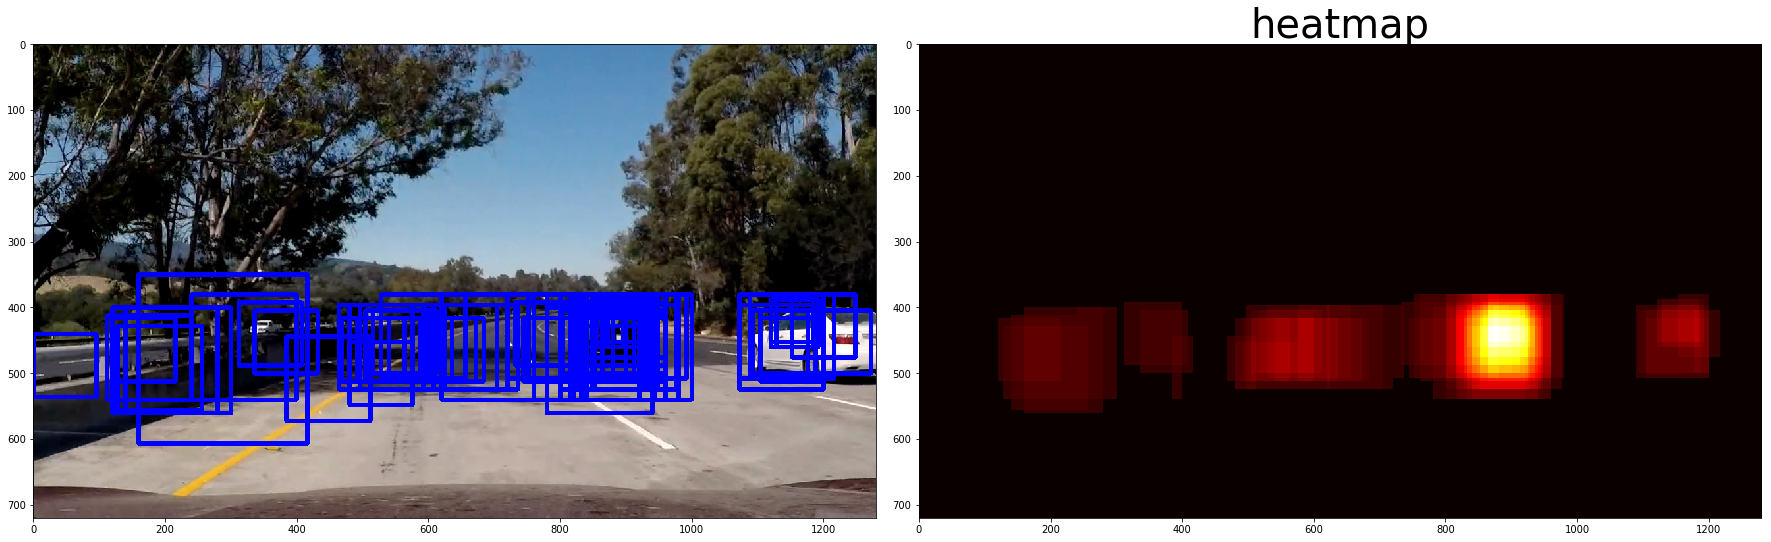

test image shape is: (720, 1280, 3)


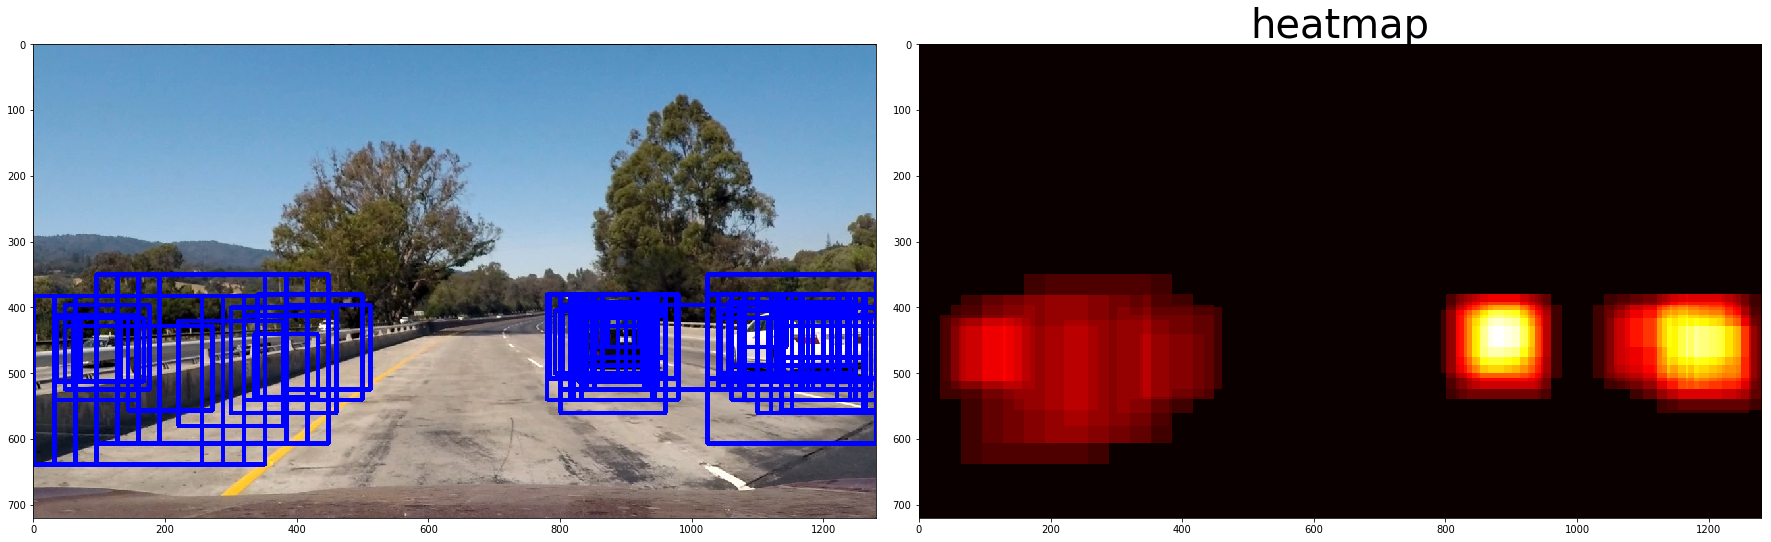

test image shape is: (720, 1280, 3)


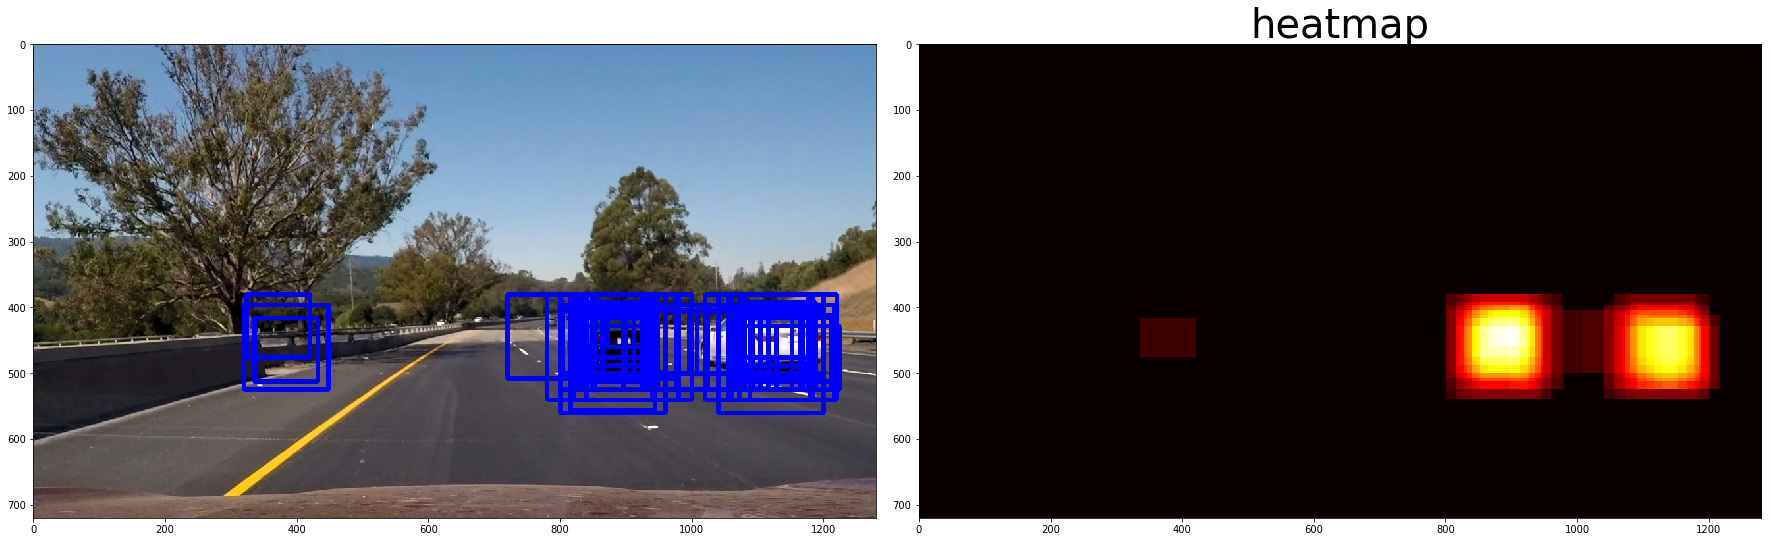

test image shape is: (720, 1280, 3)


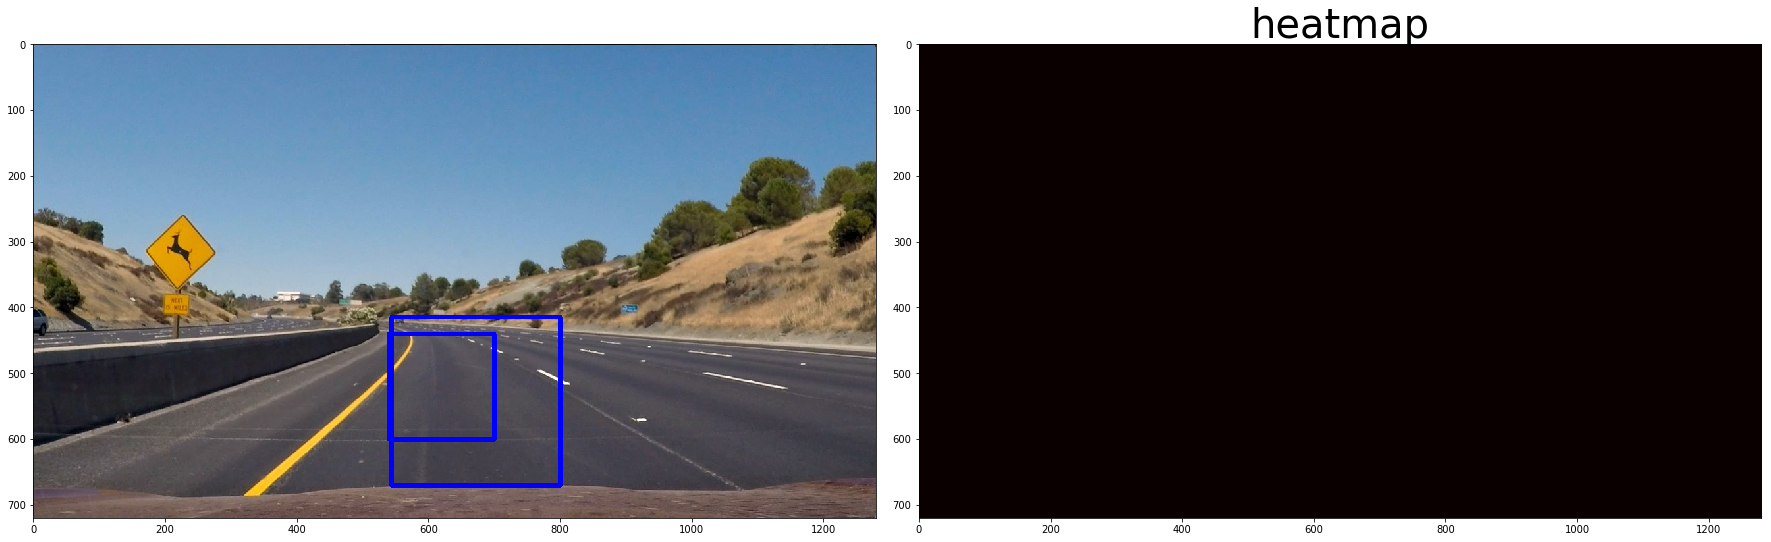

test image shape is: (720, 1280, 3)


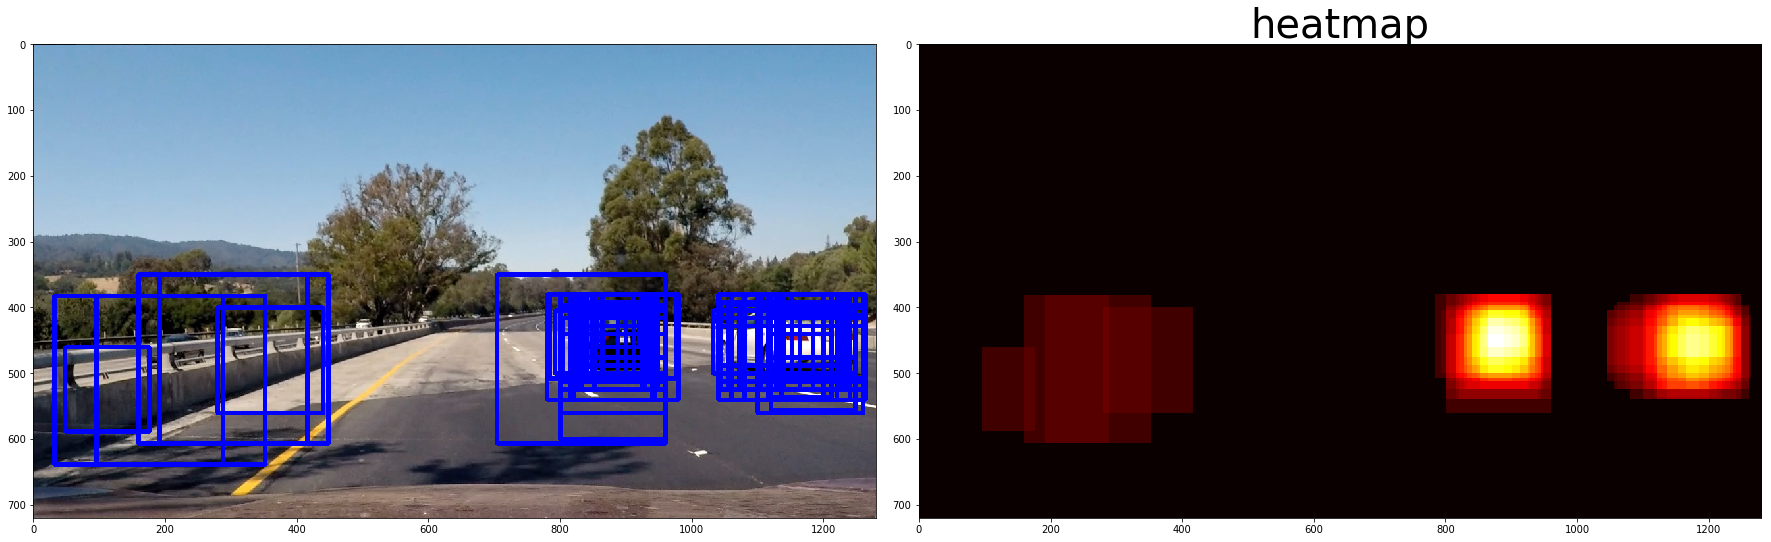

test image shape is: (720, 1280, 3)


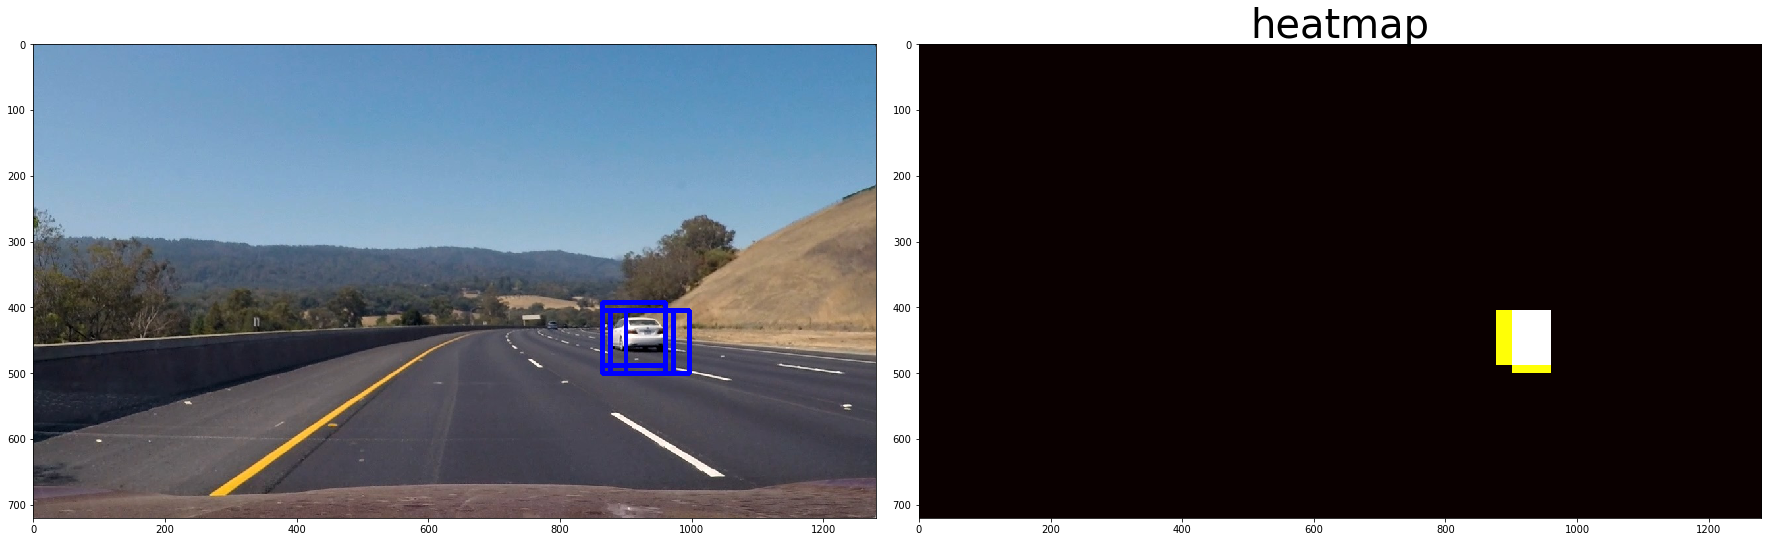

In [26]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

class ImageProcessor():
    def __init__(self, win_search):
        win_search = win_search

    def call(self, image):
        draw_image = np.copy(image)

        heatmap = np.zeros((image.shape[0], image.shape[1]), np.uint8)

        hot_windows = win_search.find_cars(image)
            
        draw_image = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(draw_image)
    
        heatmap = add_heat(heatmap, hot_windows)

        heatmap = apply_threshold(heatmap,2) 
        
        ax2.imshow(heatmap, cmap='hot')
        ax2.set_title('heatmap', fontsize=40)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

        # Find final boxes from heatmap using label function
        labels = label(heatmap)

        # draw the bounding box on the image 
        draw_image = np.copy(image)
        draw_image = draw_labeled_bboxes(draw_image, labels)

        return draw_image


impro = ImageProcessor(win_search)

images = glob.glob("./test_images/test*.jpg")
        
for each in images:
    time1 = time.time()
    image = mpimg.imread(each)
    
    print("test image shape is:", image.shape)
    draw_image = impro.call(image)        

In [37]:
from image_processor import *
impro = ImageProcessor(win_search)
        
for each in images:
    time1 = time.time()
    image = mpimg.imread(each)
    
    print("test image shape is:", image.shape)
    draw_image = impro.call(image)        
    plt.imshow(draw_image)
    plt.show()

In [34]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


output_file = 'test_video_out.mp4'
input_clip = VideoFileClip("test_video.mp4")
output_clip = input_clip.fl_image(impro.call) 
%time output_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [01:14<00:01,  1.96s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 1min 14s, sys: 124 ms, total: 1min 14s
Wall time: 1min 16s


In [35]:
output_file = 'project_video_output.mp4'
input_clip = VideoFileClip("project_video.mp4")
output_clip = input_clip.fl_image(impro.call) 
%time output_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [40:54<00:01,  1.94s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 40min 46s, sys: 1.5 s, total: 40min 48s
Wall time: 40min 56s


In [1]:
from object_detection_net import *

cnn = ObjectDetectionNet()
cnn.build_model()

Using TensorFlow backend.


In [2]:
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [3]:
cnn.load_weights()

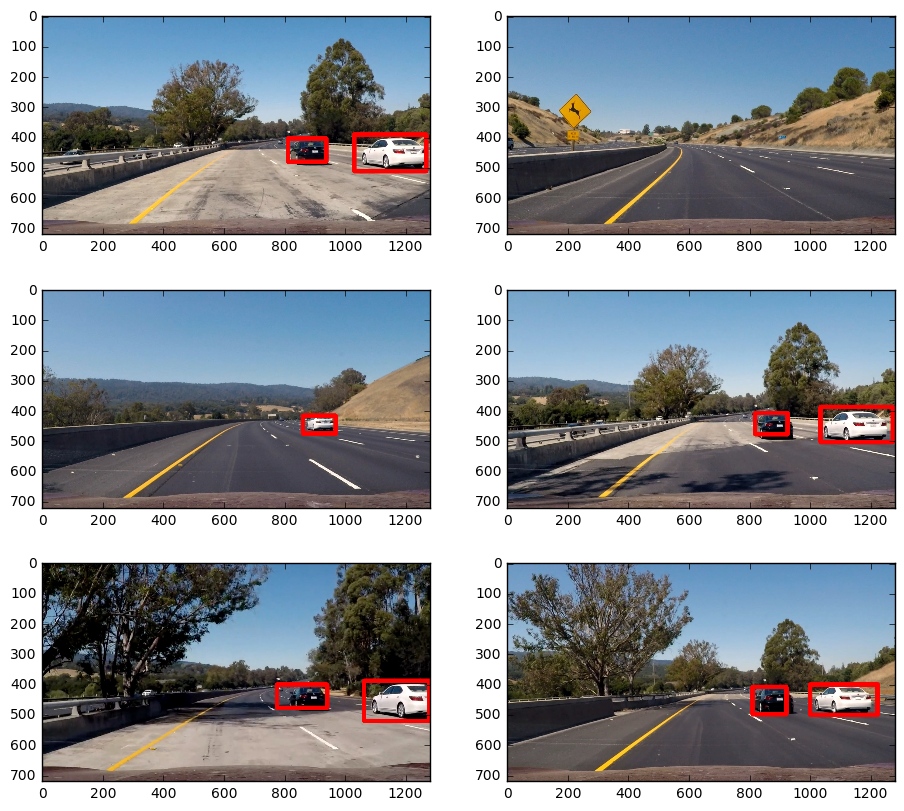

In [4]:
import glob

images = [plt.imread(file) for file in glob.glob('./test_images/*.jpg')]
batch = np.array([np.transpose(cv2.resize(image[300:650,500:,:],(448,448)),(2,0,1)) 
                  for image in images])

batch = 2*(batch/255.) - 1

out = cnn.model.predict(batch)

f,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(11,10))
for i,ax in zip(range(len(batch)),[ax1,ax2,ax3,ax4,ax5,ax6]):
    boxes = out_to_car_boxes(out[i], threshold = 0.17)
    ax.imshow(draw_box(boxes,images[i],[[500,1280],[300,650]]))

plt.show()

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


output_file = 'project_video_lane.mp4'
input_clip = VideoFileClip("project_video_lane_out.mp4")
output_clip = input_clip.fl_image(cnn.pipeline) 
%time output_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_video_lane.mp4
[MoviePy] Writing video project_video_lane.mp4


100%|█████████▉| 1260/1261 [17:19<00:00,  1.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lane.mp4 

CPU times: user 1h 45min 16s, sys: 4min 35s, total: 1h 49min 52s
Wall time: 17min 20s
